# Deep Learning for Robotics Week 02: 
## A Model for Inverse Kinematics and Controls

### Tutorial

In the previous weeks tutorial we had looked into a neural network model for a prediction task. Namely, to predict whether or not a collision was about to occur. However, we can also use deep learning to control the robot after it has made some decision. The canoncial example of this (at least in my opinion) is grasping. Given some sort of robotic appendage with an end effector capable of grasping an object, how can we accomplish that, and in this case how can we accomplish that with a neural network? The goal may be easy to specify -- reach out and grab that cylinder -- but doing it effectively and generalizing to new situations is difficult.

In this grasping problem we have two spaces we are worried about. Task space is the typical cartesian space describing the position of an object relative to some origin. Configuration space can be higher dimensional and describes the joint angles of the robot or robotic piece. In order to move the end-effector to some goal position we need to be able to describe the changes in its joint angles. This is what we call Inverse Kinematics (IK). Forward Kinematics (FK) is the opposite process, from joint angles to Euclidean location.

We can easily solve the problem of IK algebraically if we consider low dimensionality siutations, both in task space and configuration case. When we increase the dimensionality and start to consider other constraints on the problem (i.e. are certain poses achievable or useful) it becomes much harder. This is where deep learning will hopefully come to save the day. 

We will only be considering the IK problem here, so our network input will be the end effector position and the output will be the joint angle pose. The dimensionality of the input can only be 2 or 3, while the output dimensionality depends on the number of joints in the robot. If the robot has many degrees of freedom then this configuration dimensionality can be huge. However, even though your human arm may have 7 degrees of freedom (which it does), most of the poses that are achievable are not unique.

### Code (Description and Changes)

The class provides a a number of files to be edited by students and two somewhat separate exercises. For the last week of this tutorial I had converted everything into TensorFlow and made it so the simulation could be run in Jupyter, but wanting to move on to different material I will keep some of this weeks material in PyTorch.

### Exercise: Dropout and Stochastic Forward Pass

In this exercise we are examining the effect that dropout and stochastic forward passes have on the effectieness of a model trained to identify MNIST handwritten digits. Stochastic forward pass is just the process of using dropout at inference time and obtaining a distribution of outputs from multiple passes. From here you then decide what you take as the output. I have completely rewritten this exercise using TensorFlow in this Jupyter notebook.

In [65]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from seaborn import histplot

First we load the MNIST data set, examine it, and preprocess it slightly.

In [66]:
#Load the MNIST data set
dataset = tf.keras.datasets.mnist
(train_data, train_labels), (test_data, test_labels) = dataset.load_data()

print('Training Data:', train_data.shape)
print('Test Data:', test_data.shape)

Training Data: (60000, 28, 28)
Test Data: (10000, 28, 28)


Image Label: 5 Image Shape: (28, 28)


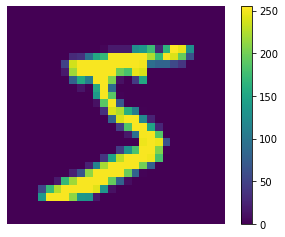

In [67]:
plt.figure()
plt.imshow(train_data[0])
plt.colorbar()
plt.axis(False)
print('Image Label:', train_labels[0], 'Image Shape:', train_data[0].shape)

We can see that we have 28x28 images with only one channel. We need to normalize our data, which we will do inside of our model, but we will reshape our data slightly before training.

In [68]:
train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))

Now we will build our model. We are rescaling the input in the first layer, and then using convolutions followed by max pooling followed by densely connected layers with a dropout. The dropout layer is what we will be using for our stochastic forward pass.

In [69]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    #Specify the input
    tf.keras.Input((28,28,1)),
    
    #Rescale the input
    layers.experimental.preprocessing.Rescaling(1./255),
    
    #The meat of the model
    layers.Conv2D(28, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    layers.Conv2D(10, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

model.summary()
tf.config.experimental.list_physical_devices('GPU')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 10)        2530      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               169100    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)              

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

We note that this is probably way more than we need for this problem, but in the interest of learning it is good. Also note that if GPU is enabled for TensorFlow the device will be printed above.

In [70]:
#Only training for two epochs, but that seems to be fine
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=2, 
            batch_size=20)

Epoch 1/2
3000/3000 [==============================] - 16s 5ms/step - loss: 1.5662 - accuracy: 0.8979
Epoch 2/2
3000/3000 [==============================] - 16s 5ms/step - loss: 1.5067 - accuracy: 0.9547


In [71]:
_, acc = model.evaluate(test_data, test_labels, verbose=0)
print('Accuracy:', acc*100.0)

Accuracy: 97.46000170707703


We seem to be getting good accuracy, but lets find an image where the network fails and then apply our stochastic forward pass.

In [72]:
#Iterate through test images looking for failure
#We will look for 10 failures

fail = []
count = 0
for i, image in enumerate(test_data):
    pred = np.argmax(model.predict(image.reshape(1,28,28,1)))
    if pred != test_labels[i]:
        fail.append((image, pred, test_labels[i]))
        
        count += 1
        
        if count>=10:
            break

Prediction:3, Actual:5


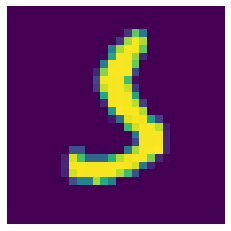

In [82]:
idx = 8 #Just pick a random index

plt.figure()
plt.imshow(fail[idx][0])
plt.axis(False);
print('Prediction:%i, Actual:%i' % (fail[idx][1], fail[idx][2]))

The image above and the prediction will change based on the learning. Anyways, we can see that the network is failing as its prediction is not the true label.

As a brief aside, the goal of this exercise is to show that stochastic forward passes can be useful in classification. In order to achieve this we need to be able to use the dropout layer in prediction. In other words we want to drop connections during inference to get a distribution of classifications. Sounds like a simple thing right? Well apparently not, and boy what a rabbit hole it was trying to figure it out. In the end I have borrowed someones code from this [GitHub issue](https://github.com/tensorflow/tensorflow/issues/28484) to define a custom dropout layer that is always "on". We then remove replace the last two layers of the model to define a new model that will use stochastic forward passes in inference.

In [76]:
class Dropout(tf.keras.layers.Layer):
    """Always-on dropout layer, i.e. it does not respect the training flag set to
    true by model.fit and false by model.predict. Unlike tf.keras.layers.Dropout,
    this layer does not return input unchanged if training=false, but always
    randomly drops a fraction self.rate of the input nodes.
    """

    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs):
        return tf.nn.dropout(inputs, self.rate)

    def get_config(self):
        """enables model.save and restoration through tf.keras.models.load_model"""
        config = super().get_config()
        config["rate"] = self.rate
        return config

In [77]:
denseW = model.layers[-1].get_weights() #Save weights from last layer
model.pop() #Remove last layer
model.pop() #Remove dropout layer

We have turned the dropout up slightly.

In [78]:
model.add(Dropout(rate=0.6)) #Add always on dropout layer
model.add(tf.keras.layers.Dense(10, activation='softmax')) #Add dense layer
model.compile()
model.layers[-1].set_weights(denseW) #Replace weights
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 10)        2530      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               169100    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

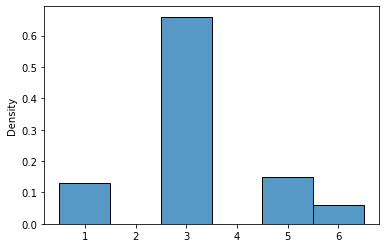

In [83]:
n=100 #Number of passes
x=fail[idx][0].reshape((1,28,28,1)) #Input that standard network fails on

dist = np.zeros(n)
for i in range(n):
    prediction = np.argmax(model.predict(x))
    dist[i] = prediction

histplot(dist, discrete=True, stat='density');

In the plot above we see the distribution of predictions made by the model with stochastic forward pass. It doesn't seem to be working too well as it is still predicted 3 to be most likely, but we can see some uncertainity. I think further investigation is needed to determine the real merit. It is possible that the convolution nature is actually hurting the ability for stochastic forward passes to be effective.

### Exercise: Inverse Kinematics

In this exercise we are training a neural network to predict the joint angles necessary to position the end affector in a specific coordinate in space. The code for this can be found in the env_sim folder, and inside each python file I have indicated the parts edited by me.

- **neural_network.py:** This file defines a network for use in predicting IK joint angles. Using PyTorch I have defined a simple linear network with dropout, and the associated forward pass function.

I have also edited a few other files to make it easy to run in Jupyter.

In [2]:
import env_sim as sim
import numpy as np

We can first look at the analytic simulation using the IK equations. Running the code below will start a simulation where you can indicate points on the screen and the robotic arm will move there if possible.

In [3]:
sim.IK_analytic_sim() #Runs analytic IK simulation

SystemExit: 

Now lets train a neural network to do the inverse Kinematics for us.

In [4]:
#Import training data
train = np.load('env_sim/data/train.npy')
data = train[:,:2]
labels = train[:,2:]

In [5]:
print('Input:', data[0])
print('Output:',labels[0])

Input: [-302. -212.]
Output: [-0.04783804 -0.99885511  0.84320638  0.53759   ]


The input is an end effector location, but we might wonder why there are four outputs as opposed to just two for the two joint angles. The four outputs are actually the sin and cos of the angles, and this allows us to squash our ouput between -1 and 1, while still retaining enough information to move the robot arm.

In [7]:
'''
The number of epochs can be changed. If GPU is not enabled then
it will not be used.
'''
model = sim.runTrain(100)

Using GPU Acceleration
Normalizing Input and Output
Training
Train Epoch: 0 	Loss: 0.463407
Train Epoch: 1 	Loss: 0.414498

Test set: Average loss: 0.3924
Train Epoch: 2 	Loss: 0.380114

Test set: Average loss: 0.3625
Train Epoch: 3 	Loss: 0.354663

Test set: Average loss: 0.3407
Train Epoch: 4 	Loss: 0.337178

Test set: Average loss: 0.3265
Train Epoch: 5 	Loss: 0.325689

Test set: Average loss: 0.3167
Train Epoch: 6 	Loss: 0.316748

Test set: Average loss: 0.3073
Train Epoch: 7 	Loss: 0.306722

Test set: Average loss: 0.2963
Train Epoch: 8 	Loss: 0.295289

Test set: Average loss: 0.2833
Train Epoch: 9 	Loss: 0.281815

Test set: Average loss: 0.2686
Train Epoch: 10 	Loss: 0.266241

Test set: Average loss: 0.2522
Train Epoch: 11 	Loss: 0.250200

Test set: Average loss: 0.2355
Train Epoch: 12 	Loss: 0.233814

Test set: Average loss: 0.2191
Train Epoch: 13 	Loss: 0.218223

Test set: Average loss: 0.2031
Train Epoch: 14 	Loss: 0.203950

Test set: Average loss: 0.1891
Train Epoch: 15 	Loss

Running the code below will run a similar simulation to the analytic version, but this time the joint angles are being calculated by the model.

In [8]:
sim.IK_NN_sim(model) #Run a simulation using network to do IK

Using GPU Acceleration


SystemExit: 

In the simulation we can see that the network is doing a great job of calculating the IK. It is perhaps slightly worse, but for the most part it is hard to tell.

This last simulation is still using the network model, but his time it is using stochastic forward passes to choose the most likely join angle.

Using GPU Acceleration


SystemExit: 

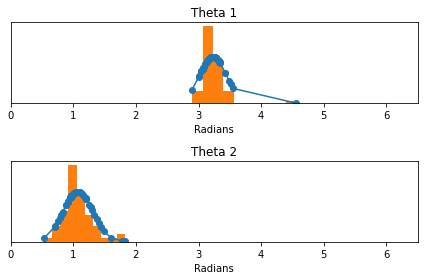

In [9]:
sim.IK_dropNN_sim(model)